In [2]:
3+6

9

# Master File

# Tools & Libraries

In [3]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [4]:
%load_ext autoreload
%autoreload
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.vis import (boxplot_histogram)

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx,
    store_bin
    )


In [5]:
from pa_lib.data import desc_col

In [6]:
from IPython.display import display
pd.options.display.max_columns = None


In [7]:
def timestamp():
    print(f"Timestamp: {dt.datetime.now()}")

In [8]:
# Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(
    job_name= "ek_info_prepare.py",
    #current = "This Week",
    current = "Today"
    ) 
# output: ek_info.feather

09:59:17 [INFO] [ipykernel_launcher.py] requests 'ek_info_prepare.py'
09:59:17 [INFO] [ipykernel_launcher.py]: Not running job 'ek_info_prepare.py': result is current ('Today') from 2020-01-27 09:36:09.507163.


# Load Dataset (Data Preparation)

In [9]:
from vkprog_data_prep import bd_train_scoring


09:59:18 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
09:59:18 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2020-01-27 09:31:57.528900.


In [10]:
dt.date(year=2019, month=12, day=2).isocalendar()

(2019, 49, 1)

http://www.whatweekisit.org/

In [11]:
%%time
# Wall time: 38.5 s

# 2019-10-21 => Calendar week 43
(training_all,
 scoring_all,
 feature_colnames_bd,
 feature_colnames_dates,
 feature_colnames_branchen
    ) = bd_train_scoring(
            day            = 27, # a Monday
            month          = 1,
            year_score     = 2020,
            year_train     = 2019,
            year_span      = 4,
            scale_features = True,
            sales_filter   = True
            #Sales Filter: Keine Langzeitverträge, Eigenwerbung, 
            #              Logistik für Dritte, politisch... etc.
            )

09:59:20 [INFO] Started loading binary file ...
09:59:20 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
09:59:20 [INFO] ... finished loading binary file in 0.19s (0.89s CPU)
09:59:23 [INFO] True: Filters applied, defined by Sales
09:59:23 [INFO] Period: KW_2
09:59:23 [INFO] Calculate Reservation...
09:59:23 [INFO] Calculate Aushang...
09:59:23 [INFO] Merge Results...
09:59:23 [INFO] aggregate_bookings: Done.
09:59:23 [INFO] current_yyyykw: 202005
09:59:23 [INFO] date_now:       2020-01-27 00:00:00
09:59:23 [INFO] training_yyyykw:201905
09:59:23 [INFO] date_training:  2019-01-28 00:00:00
09:59:46 [INFO] Scaling features
09:59:48 [INFO] Finished.
Wall time: 28.4 s


In [12]:
print(f"training_all.shape: {training_all.shape}")
print(f"scoring_all.shape: {scoring_all.shape}")
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())

training_all.shape: (12604, 309)
scoring_all.shape: (12703, 309)

training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_11,Netto_Sum_Aus_RY_4_KW_13,Netto_Sum_Aus_RY_4_KW_15,Netto_Sum_Aus_RY_4_KW_17,Netto_Sum_Aus_RY_4_KW_19,Netto_Sum_Aus_RY_4_KW_21,Netto_Sum_Aus_RY_4_KW_23,Netto_Sum_Aus_RY_4_KW_25,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_5,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Aus_RY_4_KW_7,Netto_Sum_Aus_RY_4_KW_9,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,N


scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_11,Netto_Sum_Aus_RY_4_KW_13,Netto_Sum_Aus_RY_4_KW_15,Netto_Sum_Aus_RY_4_KW_17,Netto_Sum_Aus_RY_4_KW_19,Netto_Sum_Aus_RY_4_KW_21,Netto_Sum_Aus_RY_4_KW_23,Netto_Sum_Aus_RY_4_KW_25,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_5,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Aus_RY_4_KW_7,Netto_Sum_Aus_RY_4_KW_9,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,N

In [13]:
set(training_all.columns == scoring_all.columns)

{True}

In [14]:
# Search for NULLS
display(desc_col(training_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
        )

display(desc_col(scoring_all)
        .sort_values("NULLS", ascending=False)
        .head(2)
       )

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12604,12604
Netto_Sum_Res_RY_4_KW_39,float64,0/12604,363


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12703,12703
Netto_Sum_Res_RY_4_KW_39,float64,0/12703,390


In [15]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

predictor: Erste_Buchung_Delta
Target_Res_flg: True


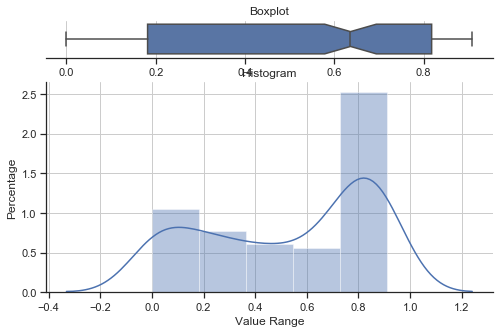

Target_Res_flg: False


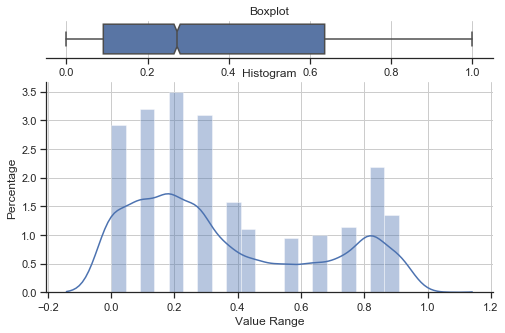


###########################################################

predictor: Letzte_Buchung_Delta
Target_Res_flg: True


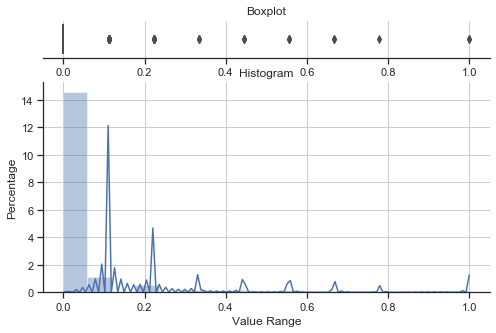

Target_Res_flg: False


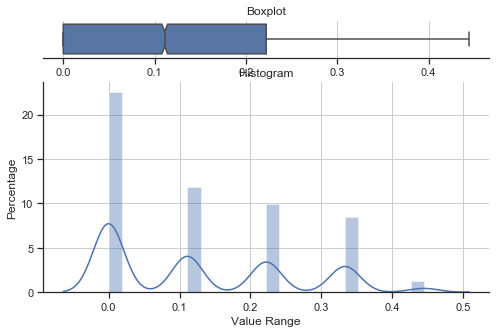


###########################################################

predictor: Erste_Letzte_Buchung_Delta
Target_Res_flg: True


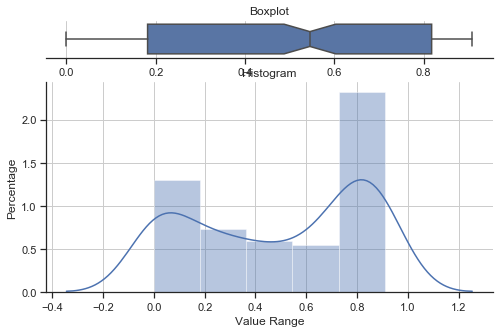

Target_Res_flg: False


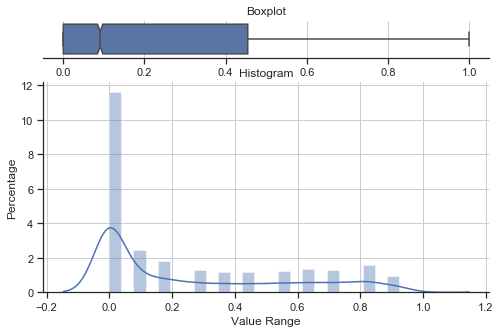


###########################################################



In [16]:
temp_df = training_all
for predictor in feature_colnames_dates:
    print(f"predictor: {predictor}")
    
    for boolean in [True, False]:
        print(f"Target_Res_flg: {boolean}")
        
        boxplot_histogram(
            temp_df.loc[temp_df.Target_Res_flg == boolean , # row filter
                        predictor ],           # column
            figsize=(8,5)
            )
    print("\n###########################################################\n")

del temp_df

## CRM Data

In [17]:
from vkprog_crm_prep  import crm_train_scoring

10:00:53 [INFO] [ipykernel_launcher.py] requests 'crm_prepare.py'
10:00:53 [INFO] [ipykernel_launcher.py]: Not running job 'crm_prepare.py': result is current ('Today') from 2020-01-27 09:05:12.898621.


In [18]:
timestamp()

(crm_train_df, crm_score_df, feature_colnames_crm) = crm_train_scoring(
    day=27, month=1, year_score=2020, year_train=2019, year_span=4
)

Timestamp: 2020-01-27 10:00:55.752063
10:00:55 [INFO] Start.
10:00:55 [INFO] Started loading binary file ...
10:00:55 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
10:00:55 [INFO] ... finished loading binary file in 0.22s (0.22s CPU)
10:01:07 [INFO] Finished.


In [19]:
crm_train_df.head(3).T

,0,1,2
Endkunde_NR,100034.0,100039.0,100043.0
RY_0_Anz_Besprechung,0.0,0.0,0.0
RY_1_Anz_Besprechung,0.0,0.0,0.0
RY_2_Anz_Besprechung,0.0,0.0,0.0
RY_3_Anz_Besprechung,0.0,0.0,0.0
RY_0_Anz_Besuch,0.0,1.0,0.0
RY_1_Anz_Besuch,0.0,0.0,0.0
RY_2_Anz_Besuch,1.0,0.0,0.0
RY_3_Anz_Besuch,3.0,0.0,0.0
RY_0_Anz_Brief_Dankeskarte,0.0,0.0,0.0


In [20]:
crm_score_df.head(3).T

,0,1,2
Endkunde_NR,100034.0,100039.0,100043.0
RY_0_Anz_Besprechung,0.0,0.0,0.0
RY_1_Anz_Besprechung,0.0,0.0,0.0
RY_2_Anz_Besprechung,0.0,0.0,0.0
RY_3_Anz_Besprechung,0.0,0.0,0.0
RY_0_Anz_Besuch,1.0,0.0,0.0
RY_1_Anz_Besuch,0.0,1.0,0.0
RY_2_Anz_Besuch,0.0,0.0,0.0
RY_3_Anz_Besuch,1.0,0.0,0.0
RY_0_Anz_Brief_Dankeskarte,0.0,0.0,0.0


In [21]:
feature_colnames_crm

['RY_0_Anz_Besprechung',
 'RY_1_Anz_Besprechung',
 'RY_2_Anz_Besprechung',
 'RY_3_Anz_Besprechung',
 'RY_0_Anz_Besuch',
 'RY_1_Anz_Besuch',
 'RY_2_Anz_Besuch',
 'RY_3_Anz_Besuch',
 'RY_0_Anz_Brief_Dankeskarte',
 'RY_1_Anz_Brief_Dankeskarte',
 'RY_2_Anz_Brief_Dankeskarte',
 'RY_3_Anz_Brief_Dankeskarte',
 'RY_0_Anz_E-Mail',
 'RY_1_Anz_E-Mail',
 'RY_2_Anz_E-Mail',
 'RY_3_Anz_E-Mail',
 'RY_0_Anz_Event_Veranstaltung',
 'RY_1_Anz_Event_Veranstaltung',
 'RY_2_Anz_Event_Veranstaltung',
 'RY_3_Anz_Event_Veranstaltung',
 'RY_0_Anz_Telefon',
 'RY_1_Anz_Telefon',
 'RY_2_Anz_Telefon',
 'RY_3_Anz_Telefon',
 'RY_0_Anz_Anderes',
 'RY_1_Anz_Anderes',
 'RY_2_Anz_Anderes',
 'RY_3_Anz_Anderes',
 'Letzter_Kontakt_Delta_Anderes',
 'Letzter_Kontakt_Delta_Besprechung',
 'Letzter_Kontakt_Delta_Besuch',
 'Letzter_Kontakt_Delta_Brief_Dankeskarte',
 'Letzter_Kontakt_Delta_E-Mail',
 'Letzter_Kontakt_Delta_Event_Veranstaltung',
 'Letzter_Kontakt_Delta_Telefon',
 'Letzter_Kontakt_Delta_global']

In [22]:
list(
        np.compress(
            ["RY" == x[0:2] for x in feature_colnames_crm], feature_colnames_crm
        )
    )

['RY_0_Anz_Besprechung',
 'RY_1_Anz_Besprechung',
 'RY_2_Anz_Besprechung',
 'RY_3_Anz_Besprechung',
 'RY_0_Anz_Besuch',
 'RY_1_Anz_Besuch',
 'RY_2_Anz_Besuch',
 'RY_3_Anz_Besuch',
 'RY_0_Anz_Brief_Dankeskarte',
 'RY_1_Anz_Brief_Dankeskarte',
 'RY_2_Anz_Brief_Dankeskarte',
 'RY_3_Anz_Brief_Dankeskarte',
 'RY_0_Anz_E-Mail',
 'RY_1_Anz_E-Mail',
 'RY_2_Anz_E-Mail',
 'RY_3_Anz_E-Mail',
 'RY_0_Anz_Event_Veranstaltung',
 'RY_1_Anz_Event_Veranstaltung',
 'RY_2_Anz_Event_Veranstaltung',
 'RY_3_Anz_Event_Veranstaltung',
 'RY_0_Anz_Telefon',
 'RY_1_Anz_Telefon',
 'RY_2_Anz_Telefon',
 'RY_3_Anz_Telefon',
 'RY_0_Anz_Anderes',
 'RY_1_Anz_Anderes',
 'RY_2_Anz_Anderes',
 'RY_3_Anz_Anderes']

In [23]:
def scaling_crm_add2master(master_df, crm_df, feature_colnames_crm):

    container_df = pd.merge(master_df, crm_df, how="left", on="Endkunde_NR")

    for col_name in list(
        np.compress(
            ["RY" == x[0:2] for x in feature_colnames_crm], feature_colnames_crm
        )
    ):

        container_df.loc[:, col_name] = container_df.loc[:, col_name].fillna(0)

        max_ = np.nanmax(container_df.loc[:, col_name])

        min_ = np.nanmin(container_df.loc[:, col_name])

        if min_ == max_:
            container_df.loc[:, col_name] = 0

        else:
            container_df.loc[:, col_name] = (container_df.loc[:, col_name] - min_) / (
                max_ - min_
            )

    for col_name in list(
        np.compress(
            ["Letzter" == x[0:7] for x in feature_colnames_crm], feature_colnames_crm
        )
    ):

        max_ = np.nanmax(container_df.loc[:, col_name])
        # -> those who have never been contacted
        #    will be put together with the max-ones.

        container_df.loc[:, col_name] = container_df.loc[:, col_name].fillna(
            max_
        )  # No more NaNs!

        min_ = np.nanmin(container_df.loc[:, col_name])

        if max_ == min_:
            container_df.loc[:, col_name] = 1

        else:
            container_df.loc[:, col_name] = container_df.loc[:, col_name] / max_
            # scaling, doesn't need 0

    return container_df

In [137]:
training_all = scaling_crm_add2master(
    master_df            = training_all,
    crm_df               = crm_train_df,
    feature_colnames_crm = feature_colnames_crm)

In [25]:
scoring_all  = scaling_crm_add2master(
    master_df            = scoring_all,
    crm_df               = crm_score_df,
    feature_colnames_crm = feature_colnames_crm
    )

In [138]:
print(training_all.shape)
print(scoring_all.shape)

(3624, 345)
(12703, 345)


# Modeling

## Define Columns: Features versus Targets

In [139]:
from itertools import compress

features = (
    feature_colnames_bd         # Booking data
    + feature_colnames_dates    # Dates related to bookings
    + feature_colnames_branchen # Branches
    + feature_colnames_crm      # CRM (customer-vkber interactions)
    )


feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

In [140]:
print(f"Number of features:\n{len(feature_columns)}\n")
print(f"Target columns:\n{target_columns}")

Number of features:
338

Target columns:
214              Target_Aus_flg
215              Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_5
217    Target_Sum_Res_RY_0_KW_5
dtype: object


## NEW SECTION: KONTAKTE-PROBLEM

How many Gpards are getting contacted per KWs (2 week periods)? 

In [141]:
from pa_lib.util import (
    cap_words,)

In [142]:
## Recursive Dependency Check:
request_job(job_name="crm_prepare.py", current= "Today") # output: bd_data.feather


15:10:13 [INFO] [ipykernel_launcher.py] requests 'crm_prepare.py'
15:10:13 [INFO] [ipykernel_launcher.py]: Not running job 'crm_prepare.py': result is current ('Today') from 2020-01-27 09:05:12.898621.


In [143]:
def load_crm_data():
    raw_data = load_bin("vkprog/crm_data_vkprog.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    #return raw_data.astype({"Endkunde_NR": "int64", "Year": "int64", "KW_2": "int64"})
    return raw_data.astype({"Year": "int64", "KW_2": "int64"})

In [144]:
raw_crm_data = load_crm_data()

15:10:14 [INFO] Started loading binary file ...
15:10:14 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
15:10:14 [INFO] ... finished loading binary file in 0.22s (0.41s CPU)


In [145]:
raw_crm_data.head()

,Betreff,Kanal,Datum,Quelle,Verantwortlich,Kuerzel,Endkunde_NR,VB_Filter_Von,VB_Filter_Bis,VB_Filter_Grund,Year,KW,KW_2,KW_4
0,Ost - Aktionen - 2014 - ACO F200 Leuchtplakate...,E-Mail,2014-10-08,Marketing,Liliane Schüpbach (REGION OST ZÜRICH),LSC,100034,NaT,NaT,NaN,2014,41,41,41
1,City ePanel Winterthur,Besuch,2014-11-03,Verkauf,Alma Coralic (REGION OST ZÜRICH),ACO,100034,NaT,NaT,NaN,2014,45,45,45
2,KMU Forum,Besuch,2014-11-27,Verkauf,Heinz Kläui (APG WINTERTHUR),HKL,100034,NaT,NaT,NaN,2014,48,47,45
3,Ost - Aktionen - 2015 - ACO_KMU Aktion_KW5-7_2015,E-Mail,2014-12-11,Marketing,Larissa Zingre (KAM ZÜRICH),LKU,100034,NaT,NaT,NaN,2014,50,49,49
4,Cafe,Besuch,2014-12-23,Verkauf,Heinz Kläui (APG WINTERTHUR),HKL,100034,NaT,NaT,NaN,2014,52,51,49


In [146]:
bd_data = load_bin("vkprog/bd_data.feather")

15:10:15 [INFO] Started loading binary file ...
15:10:15 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
15:10:16 [INFO] ... finished loading binary file in 0.16s (0.86s CPU)


In [147]:
gpard_contacted_year_kw_df = pd.concat(
    [
        bd_data.loc[:, ["ENDKUNDE_NR", "KAMP_ERFASS_JAHR", "KAMP_ERFASS_KW_2"]]
        .astype({"KAMP_ERFASS_JAHR": "int64", "KAMP_ERFASS_KW_2": "int64"})
        .rename(
            columns={
                "ENDKUNDE_NR": "Endkunde_NR",
                "KAMP_ERFASS_JAHR": "Year",
                "KAMP_ERFASS_KW_2": "KW_2",
            }
        ),
        raw_crm_data.loc[:, ["Endkunde_NR", "Year", "KW_2"]].astype(
            {"Endkunde_NR": "int64"}
        ),
    ]
).drop_duplicates().reset_index(inplace=False).iloc[:,1:]

In [148]:
gpard_contacted_year_kw_df.head(5)

,Endkunde_NR,Year,KW_2
0,316770,2008,41
1,119642,2008,41
2,136654,2008,41
3,504874,2008,41
4,503301,2008,41


In [150]:
heatmap_anz_contacts_df = pd.pivot_table(
    gpard_contacted_year_kw_df,
    values="Endkunde_NR",
    index=["Year"],
    columns=["KW_2"],
    aggfunc=np.count_nonzero,
    fill_value=0,
)

In [151]:
heatmap_anz_contacts_df.apply(lambda x : x/1000)

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Year,,,,,,,,,,,,,,,,,,,,,,,,,,
2007,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.003,0.003,0.001,0.001
2008,0.004,0.003,0.005,0.001,0.004,0.004,0.013,0.006,0.020,0.008,0.010,0.010,0.016,0.026,0.008,0.025,0.016,0.053,0.038,0.495,0.437,0.587,0.348,0.398,0.688,0.368
2009,0.723,0.601,0.837,0.654,0.738,0.610,0.779,0.716,1.237,0.734,0.572,0.759,0.522,0.890,0.579,0.682,0.572,0.941,0.604,1.035,0.891,1.050,0.768,0.719,0.893,0.788
2010,0.566,0.630,0.940,0.601,0.940,0.625,0.785,1.141,1.140,0.594,0.822,0.728,0.848,0.574,0.808,0.573,0.536,0.967,0.616,0.978,0.958,0.936,0.938,0.959,0.628,0.724
2011,0.623,0.711,1.125,0.761,1.411,0.827,1.053,0.683,0.919,0.722,0.862,0.618,0.832,0.814,0.631,0.832,0.674,1.050,0.713,1.138,0.991,1.049,0.934,0.969,0.689,0.809
2012,0.519,0.693,0.978,0.720,0.963,0.661,1.013,1.155,1.193,0.894,0.864,0.628,0.805,0.657,0.632,0.767,0.671,1.012,0.638,1.290,1.095,1.013,0.769,0.910,0.620,0.438
2013,0.758,0.778,1.038,0.789,0.948,0.770,0.861,1.258,1.288,0.717,0.889,0.655,0.613,0.842,0.601,0.759,0.613,1.228,0.721,1.177,1.255,1.246,0.857,1.007,0.709,0.497
2014,0.793,0.862,2.514,1.501,2.291,2.508,4.321,2.505,4.366,1.884,9.882,4.555,2.454,1.895,1.360,1.433,2.680,3.174,2.650,4.232,6.427,2.677,1.733,2.701,10.606,3.168
2015,2.698,3.127,3.215,3.028,5.200,2.578,4.302,2.930,2.427,1.924,8.829,4.186,4.194,6.111,1.699,4.082,3.560,3.942,4.743,4.757,5.482,14.367,3.118,4.600,2.759,2.524


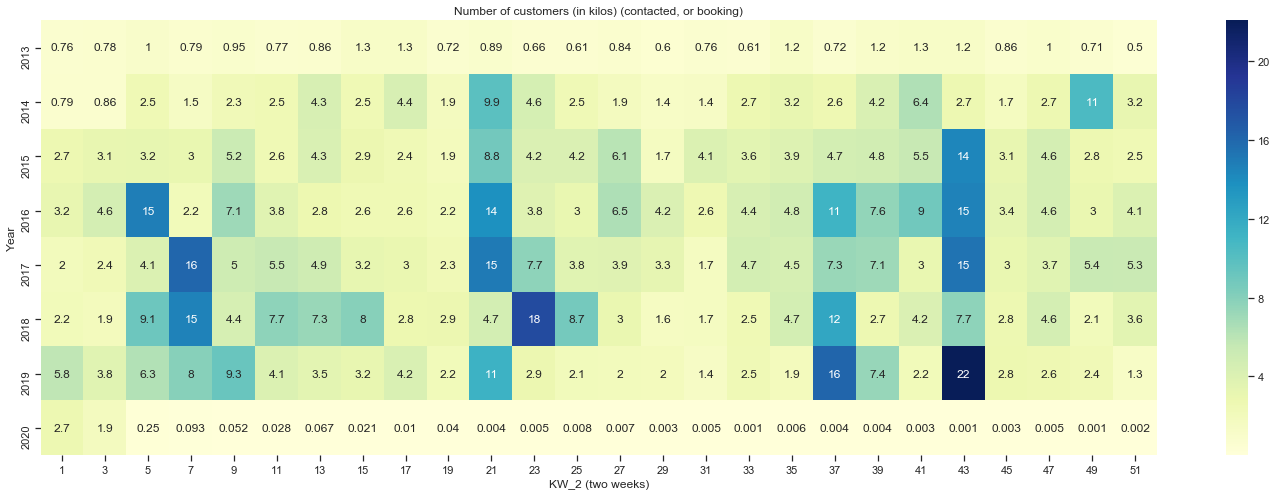

In [152]:
plt.figure(figsize=(25, 8))
ax = sns.heatmap(
    heatmap_anz_contacts_df.loc[list(range(2013, 2021)), :].apply(lambda x: x / 1000),
    annot=True,
    cmap="YlGnBu",
)
plt.title("Number of customers (in kilos) (contacted, or booking)")
plt.ylabel("Year")
plt.xlabel("KW_2 (two weeks)")
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.show()  # ta-da!

In [153]:
contacted_gpards_rows = gpard_contacted_year_kw_df.Year.isin(
    [2018]
) & gpard_contacted_year_kw_df.KW_2.isin([5])

contacted_endkunde_set = set(
    gpard_contacted_year_kw_df.loc[contacted_gpards_rows, "Endkunde_NR"]
)

In [154]:
desc_col(training_all.loc[training_all.Endkunde_NR.isin(contacted_endkunde_set),:]).head(1)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/3624,3624


In [155]:
training_all = training_all.loc[training_all.Endkunde_NR.isin(contacted_endkunde_set),:]

In [157]:
training_all.loc[:,feature_columns].head(5)

,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_11,Netto_Sum_Aus_RY_4_KW_13,Netto_Sum_Aus_RY_4_KW_15,Netto_Sum_Aus_RY_4_KW_17,Netto_Sum_Aus_RY_4_KW_19,Netto_Sum_Aus_RY_4_KW_21,Netto_Sum_Aus_RY_4_KW_23,Netto_Sum_Aus_RY_4_KW_25,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_5,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Aus_RY_4_KW_7,Netto_Sum_Aus_RY_4_KW_9,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_51,Netto_Sum_Res_RY_2_KW_7,Netto_Sum_Res_RY_2_KW_9,Netto_Sum_Res_RY_3_KW_1,Netto_Sum_Res_RY_3_KW_11,Netto_Sum_Res_RY_3_KW_13,Netto_S

## Balance Training Dataset: SMOTE

In [158]:
df_features = (
    training_all
    .loc[:,feature_columns]
    .to_numpy()
    )

df_target   = (
    training_all
    .loc[:, "Target_Res_flg"]
    .to_numpy()
    )

In [159]:
df_features

array([[0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.00717044],
       [0.        , 0.        , 0.        , ..., 0.16247906, 0.02958904,
        0.00275786],
       [0.        , 0.        , 0.        , ..., 1.        , 0.19726027,
        0.07666851],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.0904578 ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.19342466,
        0.04908991]])

In [160]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(
    random_state = 42,
    n_jobs = -1,
    )

(X_train_smote, y_train_smote) = sm.fit_resample(df_features, df_target)

In [165]:
import statsmodels as stats

In [166]:
print('y_train_smote:')
print(pd.DataFrame(y_train_smote).groupby(0)[0].count())
print(stats.describe(y_train_smote))

y_train_smote:
0
False    3463
True     3463
Name: 0, dtype: int64


AttributeError: module 'statsmodels' has no attribute 'describe'

In [167]:
df_features_smote = pd.DataFrame(X_train_smote, columns=feature_columns)

## Recursive Feature Elimination with Random Forest

- https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
- https://scikit-learn.org/stable/modules/model_evaluation.html

### Remove all highly correlated features

In [169]:
def list_correlated_features(dataframe,correlation_cutoff=0.8):
    correlated_features = set()
    correlation_matrix  = (dataframe.loc[:,feature_columns]
                                   .corr()
                          )

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_cutoff:
                #colname = (correlation_matrix.columns[i], correlation_matrix.columns[j])
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    return correlated_features

In [170]:
high_correlation = (
    list_correlated_features(
        dataframe=df_features_smote,
        correlation_cutoff=0.8
        )
    )

In [171]:
high_correlation

{'Erste_Letzte_Buchung_Delta',
 'Letzter_Kontakt_Delta_global',
 'Netto_Sum_Res_RY_0',
 'Netto_Sum_Res_RY_1',
 'Netto_Sum_Res_RY_2',
 'Netto_Sum_Res_RY_3',
 'RY_1_Anz_E-Mail',
 'RY_2_Anz_E-Mail',
 'RY_3_Anz_Besuch',
 'RY_3_Anz_E-Mail'}

In [172]:
feature_columns_01 = (
    pd.Series(
        compress(
            feature_columns,
            ~feature_columns.isin(high_correlation) # kick all redundant ones
            )
        )
    )

In [173]:
# Check that I kicked the right ones:
len(feature_columns) == len(feature_columns_01) + len(high_correlation)

True

In [174]:
from sklearn.ensemble import (
    RandomForestClassifier
    )

from sklearn.feature_selection import (
    RFECV
    )

from sklearn.model_selection import (
    StratifiedKFold
    )

In [175]:
rfc = RandomForestClassifier(
    random_state = 42,
    n_estimators = 10, # 100 is new default in v0.22
    class_weight = "balanced", # balance classes!
    n_jobs= -1         # use all CPUs
    )

rfecv = RFECV(
    estimator = rfc,
    step      = 1,     # number of features to remove at each iteration
    cv        = StratifiedKFold(n_splits = 2),  # Cross-Validation
    scoring   = "recall"  # "accuracy", "recall", "f1" etc.
    )

In [176]:
%%time
#Wall time: 32min 45s

import warnings
warnings.filterwarnings('ignore')

rfecv.fit(
    df_features_smote.loc[:,feature_columns_01], # pd.Dataframes okay!
    y_train_smote
    )

Wall time: 3min 57s


RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='recall', step=1,
      verbose=0)

In [177]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 306


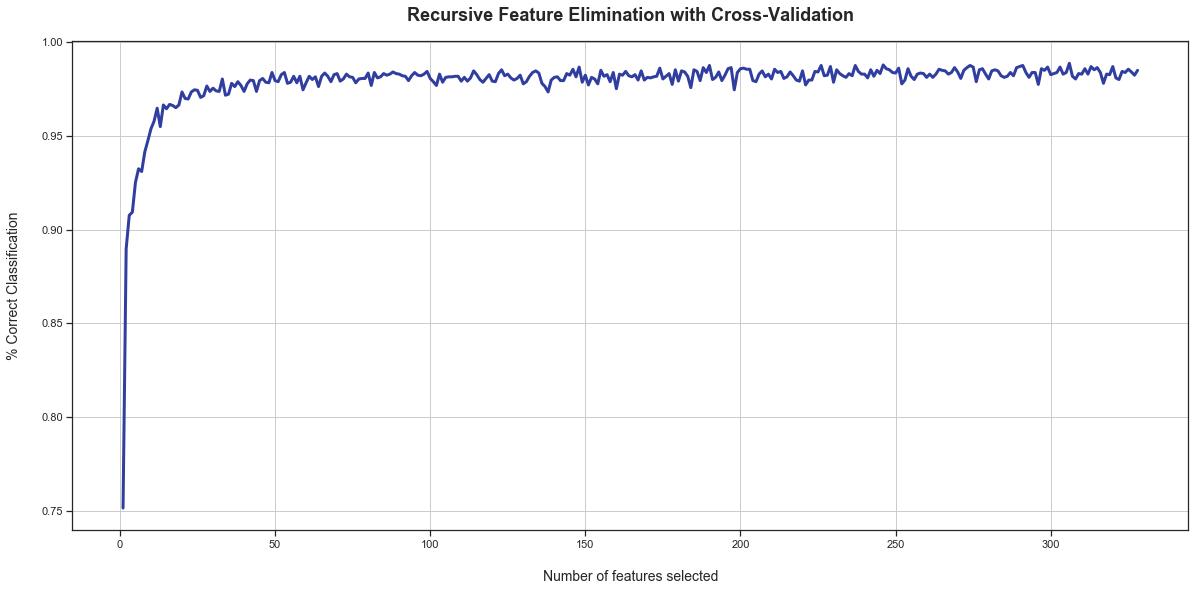

Wall time: 154 ms


In [178]:
%%time

plt.figure(figsize=(20, 9))
plt.grid()

plt.title('Recursive Feature Elimination with Cross-Validation',
          fontsize=18,
          fontweight='bold',
          pad=20)

plt.xlabel('Number of features selected',
           fontsize=14,
           labelpad=20)

plt.ylabel('% Correct Classification',
           fontsize=14,
           labelpad=20)

plt.plot(range(1, len(rfecv.grid_scores_) + 1),
         rfecv.grid_scores_,
         color='#303F9F',
         linewidth=3)

plt.show()

In [179]:
kicked_features = set(feature_columns_01[np.where(rfecv.support_ == False)[0]])
print(f"This features get kicked:\n{kicked_features}")

This features get kicked:
{'B170', 'B339', 'B165', 'B185', 'B357', 'B455', 'B160', 'B116', 'B447', 'B105', 'B448', 'B695', 'Netto_Sum_Aus_RY_4_KW_31', 'B110', 'B356', 'B351', 'B330', 'B155', 'B349', 'B135', 'B446', 'B140'}


In [180]:
# Keep only good features:
feature_columns_02 = (
    feature_columns_01[ np.where(rfecv.support_ == True)[0] ]
    )
#print(feature_columns_02)

In [181]:
# Have I kicked the right features?
len(rfecv.estimator_.feature_importances_) == len(feature_columns_02)

True

61


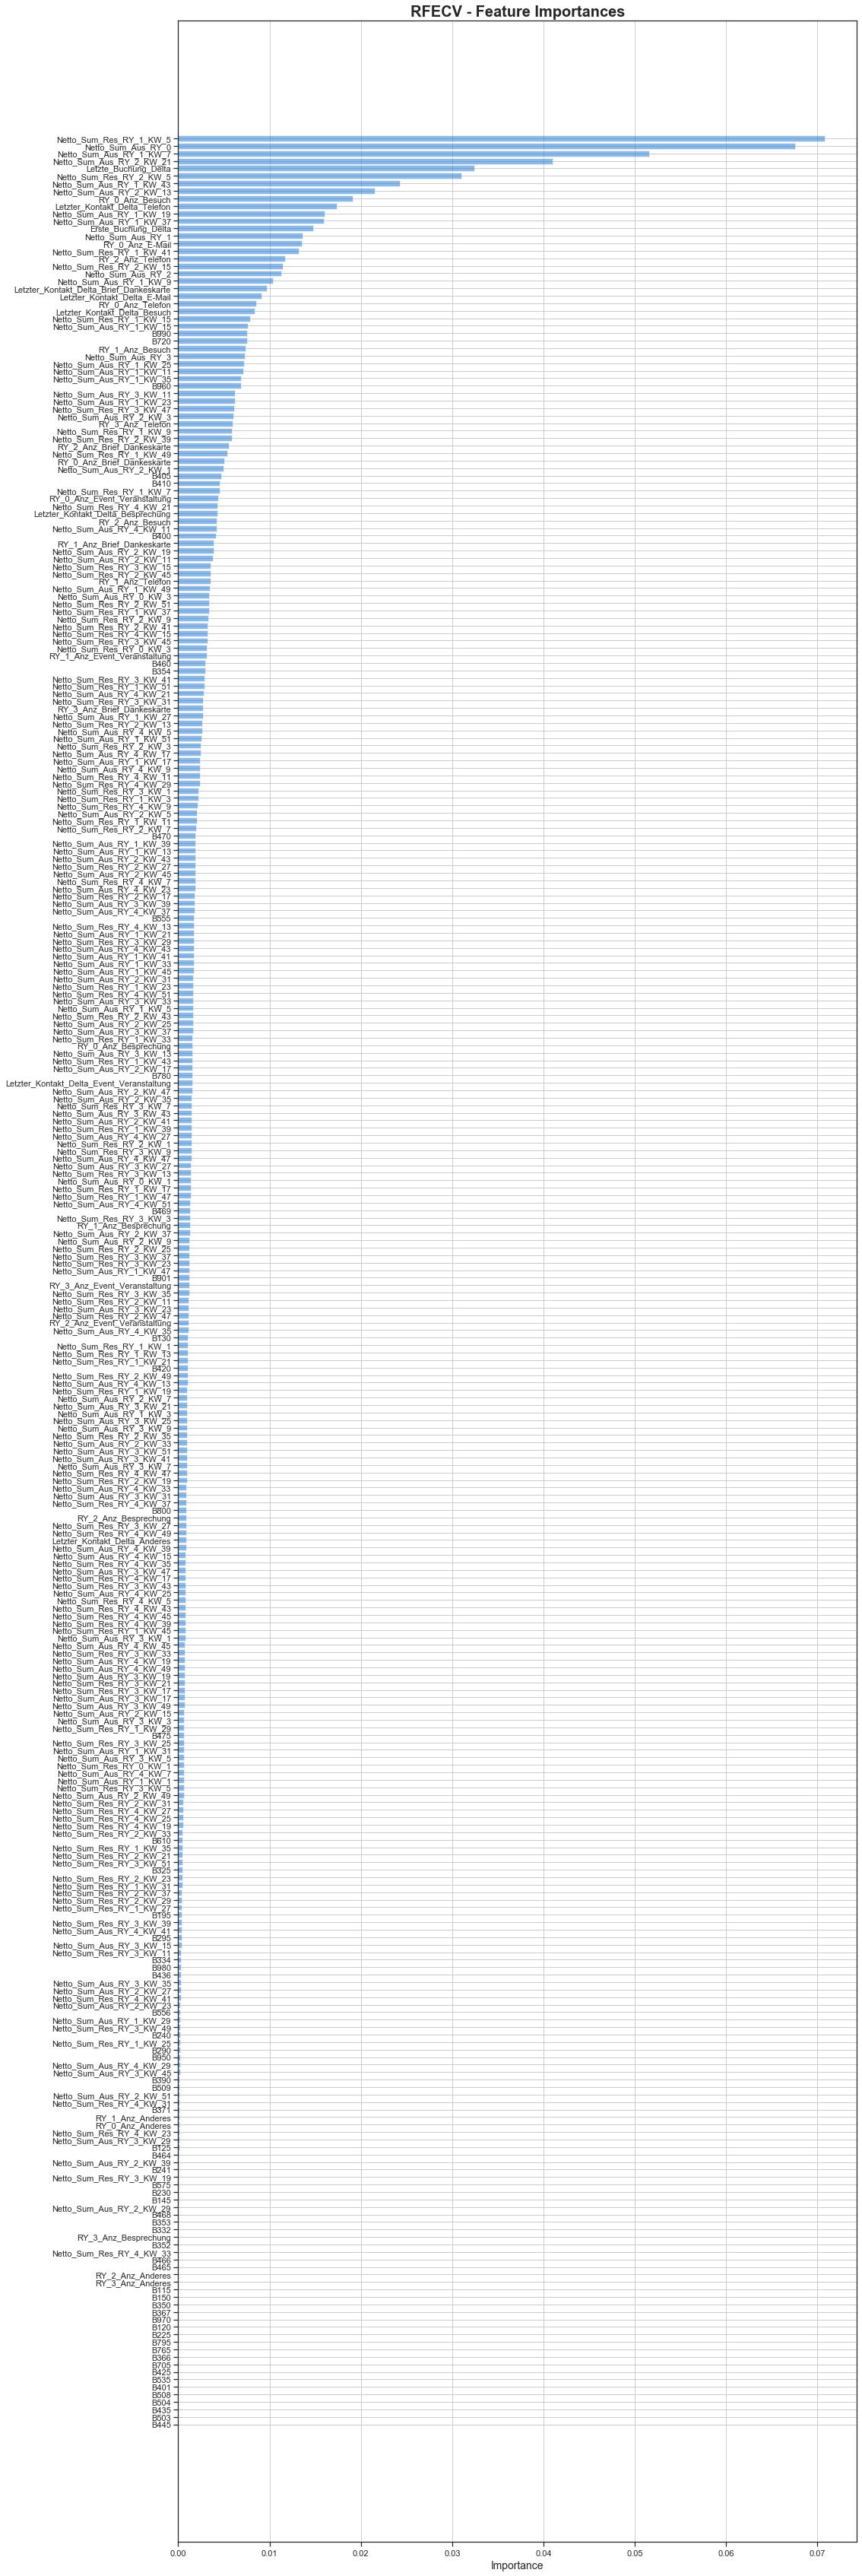

In [182]:
dset               = pd.DataFrame()
dset['attr']       = feature_columns_02
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)

height = len(feature_columns_02)//5
print(height)

plt.figure(figsize=(16, height ))
plt.grid()

plt.barh(
    y     = dset['attr'],
    width = dset['importance'],
    color = '#1976D2',
    alpha = 0.5
    )

plt.title(
    'RFECV - Feature Importances',
    fontsize=20,
    fontweight='bold',
    #pad=2
    )

plt.xlabel(
    'Importance',
    fontsize=14,
    #labelpad=20
    )
plt.show()

In [184]:
print(f"Final feature selection:\n{feature_columns_02}")
print("Count:",len(feature_columns_02))

Final feature selection:
0                        Netto_Sum_Aus_RY_0_KW_1
1                        Netto_Sum_Aus_RY_0_KW_3
2                        Netto_Sum_Aus_RY_1_KW_1
3                       Netto_Sum_Aus_RY_1_KW_11
4                       Netto_Sum_Aus_RY_1_KW_13
5                       Netto_Sum_Aus_RY_1_KW_15
6                       Netto_Sum_Aus_RY_1_KW_17
7                       Netto_Sum_Aus_RY_1_KW_19
8                       Netto_Sum_Aus_RY_1_KW_21
9                       Netto_Sum_Aus_RY_1_KW_23
10                      Netto_Sum_Aus_RY_1_KW_25
11                      Netto_Sum_Aus_RY_1_KW_27
12                      Netto_Sum_Aus_RY_1_KW_29
13                       Netto_Sum_Aus_RY_1_KW_3
14                      Netto_Sum_Aus_RY_1_KW_31
15                      Netto_Sum_Aus_RY_1_KW_33
16                      Netto_Sum_Aus_RY_1_KW_35
17                      Netto_Sum_Aus_RY_1_KW_37
18                      Netto_Sum_Aus_RY_1_KW_39
19                      Netto_Sum_Aus_RY_1_K

## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [185]:
X_train_smote_optimised_features = (
    df_features_smote
        .loc[:,feature_columns_02]
        .to_numpy()
    )

In [186]:
print(f"Shape: {X_train_smote_optimised_features.shape}")

Shape: (6926, 306)


In [187]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X_train_smote_optimised_features,
    y_train_smote,
    train_size=0.75,
    random_state=42
    )

In [189]:
print("\nX_train.shape:  ", X_train.shape)
print("y_train.shape:    ", y_train.shape)
print("\nX_test.shape.:  ", X_test.shape)
print("y_test.shape:     ",  y_test.shape)


X_train.shape:   (5194, 306)
y_train.shape:     (5194,)

X_test.shape.:   (1732, 306)
y_test.shape:      (1732,)


In [190]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(list(stats.describe(y_test)))


y_train:
0
False    2577
True     2617
Name: 0, dtype: int64
DescribeResult(nobs=5194, minmax=(False, True), mean=0.5038505968425105, variance=0.2500333117779992, skewness=-0.0154028441357134, kurtosis=-1.9997627523925312)

y_test:
0
False    886
True     846
Name: 0, dtype: int64
[1732, (False, True), 0.4884526558891455, 0.25001100700045226, 0.046201699262755136, -1.9978654029852339]


## Model Training

### Logistic Regression (base model)

In [191]:
from sklearn.linear_model import LogisticRegression

In [192]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(
    n_jobs       = -1, # all cpus
    solver       = "sag",
    class_weight = "balanced",
    max_iter     = 100000,
    C            = 1000 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train,
        y_train
        ) # bigger C

Wall time: 40.9 s


In [193]:
print(f"Training set score: {logreg_C1000.score(X_train, y_train)}")
print(f"Test set score: {logreg_C1000.score(X_test, y_test)}")

Training set score: 0.9503273007316134
Test set score: 0.918013856812933


In [194]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(
    n_jobs       = -1, # all cpus
    solver       = "sag",
    max_iter     = 100000,
    class_weight = "balanced",
    C            = 0.001 #adjustable, bigger mean less restriction on coefficients
    ).fit(
        X_train,
        y_train
        ) # bigger C

Wall time: 223 ms


In [195]:
print(f"Training set score: {logreg_C0001.score(X_train,y_train)}")
print(f"Test set score:     {logreg_C0001.score(X_test, y_test)}")

Training set score: 0.7104351174432036
Test set score:     0.7072748267898383


#### Plot Coefficients

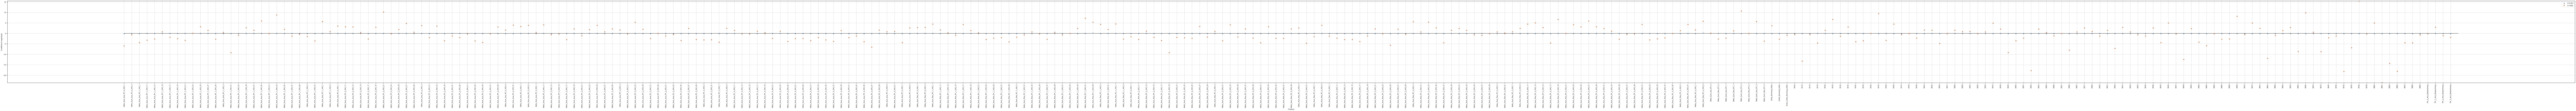

In [196]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(len(feature_columns_02),10))

plt.grid()

plt.plot(logreg_C0001.coef_.T,
         '^',
         label="C=0.001"
        )

plt.plot(logreg_C1000.coef_.T,
         'o',
         label="C=1000"
        )

plt.xticks(range(len(feature_columns_02)),
           feature_columns,
           rotation=90
          )

plt.hlines(0, 0, len(feature_columns_02))

plt.ylim(min(logreg_C1000.coef_.T),
         max(logreg_C1000.coef_.T)
        )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('LogReg_Coefficient_Importance.png')

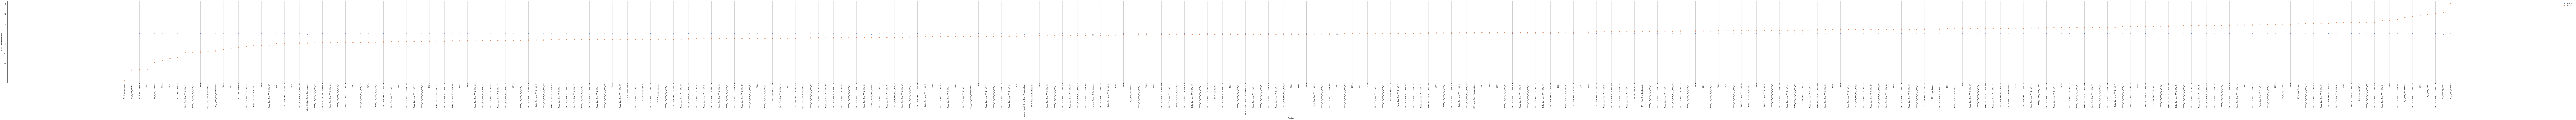

In [197]:
test_df = (
    pd.DataFrame(
        data={'feature': pd.Series(feature_columns_02), 
              'C1000':   list(logreg_C1000.coef_.T),
              'C0001':   list(logreg_C0001.coef_.T)}
    )
    .sort_values(by=['C1000'])
    .reset_index()
    )
    
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(len(feature_columns_02),10))
plt.grid()

plt.plot(
    test_df.loc[:,'C0001'],
    '^', 
    label="C=0.001"
    )

plt.plot(
    test_df.loc[:,'C1000'],
    'o',
    label="C=1000"
    )


plt.xticks(
    range(len(feature_columns_02)),
    test_df.loc[:,'feature'],
    rotation=90
    )

plt.hlines(0, 0, len(feature_columns_02))

plt.ylim(
    min(logreg_C1000.coef_.T)-1,
    max(logreg_C1000.coef_.T)+1
    )

plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

del test_df

### Model Training: Random Forest

In [198]:
from sklearn.ensemble import RandomForestClassifier

In [199]:
%%time 
# Wall time: 13min
timestamp()


forest_01 = RandomForestClassifier(
    n_estimators = 5*10**3,
    max_depth    = 7,
    criterion    = 'entropy',  #criterion='gini', "entropy"
    random_state = 42,
    bootstrap    = True,   # True is default
    class_weight = "balanced_subsample", # weights are computed based on each bootstrap sample 
    n_jobs       = -1  #using all processors. 
    )

forest_01.fit(
    X_train,
    y_train
    )

Timestamp: 2020-01-27 15:21:10.057913
Wall time: 10.2 s


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [200]:
%%time
# %% Validate Accuracy
print(f"Accuracy on unbalanced training set: {forest_01.score(X_train, y_train)}")
print(f"Accuracy on test set (validation):   {forest_01.score(X_test,  y_test)}")

Accuracy on unbalanced training set: 0.9811320754716981
Accuracy on test set (validation):   0.9480369515011547
Wall time: 1.72 s


In [201]:
# %% Plot: Feature importance
def plot_feature_importances(
        model,
        feature_columns,
        figsize=(15,len(feature_columns)//5)
        ):
    
    from operator import itemgetter
    
    dict_feature_importance = sorted(
        dict(
            zip(feature_columns,model.feature_importances_)
        ).items(),
        key=itemgetter(1)
        )
    
    n_features = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    
    plt.barh(
        np.arange(n_features),
        [y for (x,y) in dict_feature_importance],
        align='center',
        alpha=0.5
        )
    
    plt.yticks(
        np.arange(n_features),
        [x for (x,y) in dict_feature_importance]
        )
    
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

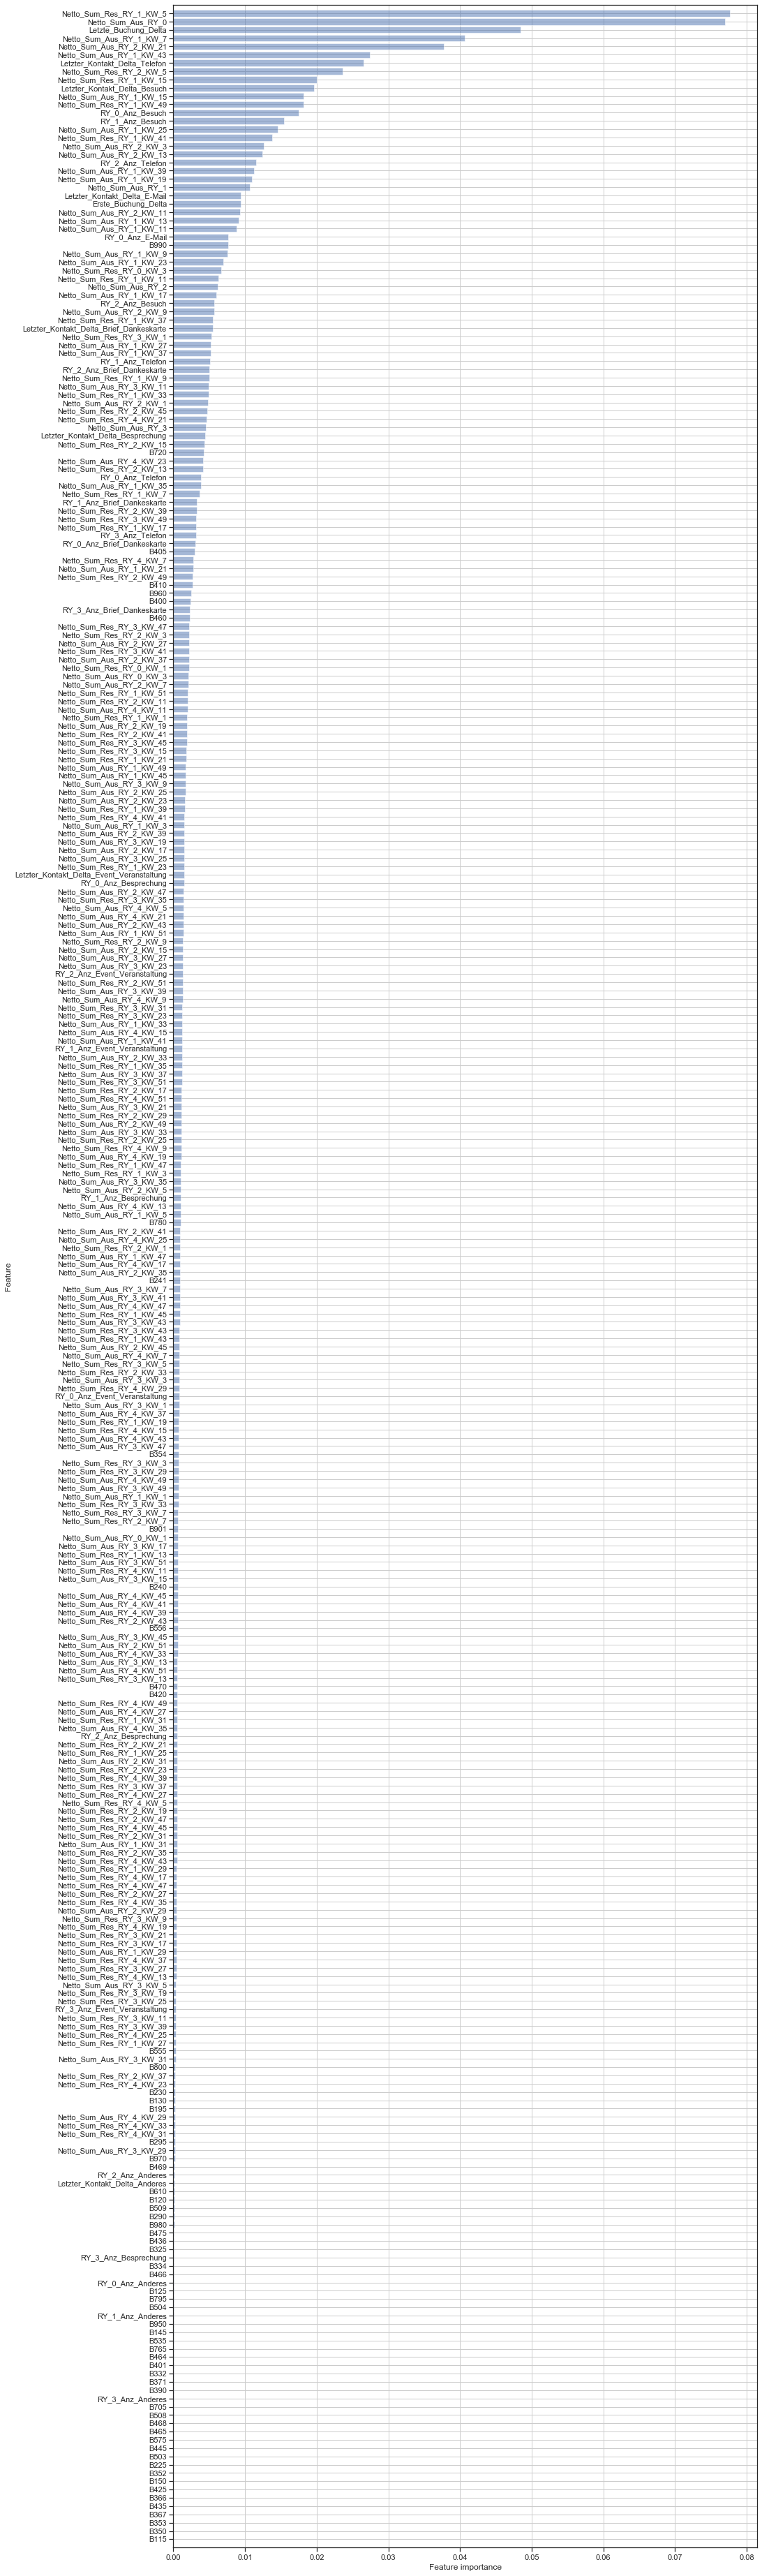

In [202]:
plot_feature_importances(
    model           = forest_01,
    feature_columns = feature_columns_02
                        )

# Model Validation

## Confusion Matrix

In [203]:
from sklearn.metrics import confusion_matrix

In [204]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01    = forest_01.predict(X_test)
    pred_logreg_C0001 = logreg_C0001.predict(X_test)
    pred_logreg_C1000 = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001 = (
        confusion_matrix(
            y_test,
            pred_logreg_C0001
            )
        )
    
    df_confusion_logreg_C0001 = (
        pd.DataFrame(
            confusion_logreg_C0001,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )
    
    confusion_logreg_C1000 = (
        confusion_matrix(
            y_test,
            pred_logreg_C1000
            )
        )
    
    df_confusion_logreg_C1000 = (
        pd.DataFrame(
            confusion_logreg_C1000,
            index   = ["Fact 0", "Fact 1"],
            columns = ["Pred 0", "Pred 1"]
            )
        )

    confusion_forest_01 = (
        confusion_matrix(
            y_test,
            pred_forest_01
            )
        )
    
    df_confusion_forest_01 = (
        pd.DataFrame(
            confusion_forest_01,
            index=["Fact 0", "Fact 1"],
            columns=["Pred 0","Pred 1"]
            )
        )

    print("Set Balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [205]:
confusion_matrices(
    X_test = X_train,
    y_test = y_train
    )

Set Balance:
True     2617
False    2577
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,2547,30
Fact 1,68,2549



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,2161,416
Fact 1,1088,1529



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,2369,208
Fact 1,50,2567


In [206]:
confusion_matrices(
    X_test = X_test,
    y_test = y_test
    )

Set Balance:
False    886
True     846
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,834,52
Fact 1,38,808



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,731,155
Fact 1,352,494



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,770,116
Fact 1,26,820


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [207]:
from sklearn.metrics import (
    classification_report
    )

In [208]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(
    classification_report(
        y_test,
        pred_logreg_C0001,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Logistic Regression C=1000:")
print(
    classification_report(
        y_test,
        pred_logreg_C1000,
        target_names=["not booking = 0", "booking = 1"]
        )
    )

print("Random Forest:")
print(
    classification_report(
        y_test,
        pred_forest_01,
        target_names=["not booking = 0", "booking = 1"]
        )
    )



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.67      0.83      0.74       886
    booking = 1       0.76      0.58      0.66       846

       accuracy                           0.71      1732
      macro avg       0.72      0.70      0.70      1732
   weighted avg       0.72      0.71      0.70      1732

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.87      0.92       886
    booking = 1       0.88      0.97      0.92       846

       accuracy                           0.92      1732
      macro avg       0.92      0.92      0.92      1732
   weighted avg       0.92      0.92      0.92      1732

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.96      0.94      0.95       886
    booking = 1       0.94      0.96      0.95       846

       accuracy                           0.95      1732
      

=> Random Forest wins.

## Precision-Recall Curve

In [209]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01,    recall_forest_01,    thresholds_forest_01
    global precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001
    global precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    
    # LogReg C=0.001
    (precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001) = (
        precision_recall_curve(
            y_test, 
            logreg_C0001.predict_proba(X_test)[:,1]
            )
        )
    
    
    # LogReg C=1000
    (precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000) = (
        precision_recall_curve(
            y_test, 
            logreg_C1000.predict_proba(X_test)[:,1]
            )
        )
    
    
    # RandomForestClassifier has predict_proba, but not decision_function
    (precision_forest_01, recall_forest_01, thresholds_forest_01) = (
        precision_recall_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )
    
    

In [210]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,
                      recall_forest_01,
                      thresholds_forest_01,
                      name,
                      dot):
        
        optimum_idx = (
            pd.Series.idxmin(
                np.power(1-pd.Series(precision_forest_01),2)
                + np.power(1-pd.Series(recall_forest_01),2)
                )
            )
        
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize = 10,
                     label      = f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle  = "none",
                     c          = 'k',
                     mew        = 2
                     )

    
    ## Apply optium_point():
    
    # Optimum: Forest 
    optimum_point(precision_forest_01,
                  recall_forest_01,
                  thresholds_forest_01,
                  name="forest_01",
                  dot='o'
                 )
    
    # Optimum: LogReg C = 0.001
    optimum_point(precision_logreg_C0001,
                  recall_logreg_C0001,
                  thresholds_logreg_C0001,
                  name="logreg_C0001",
                  dot='x'
                 )
    
    # Optimum: LogReg C = 1000
    optimum_point(precision_logreg_C1000,
                  recall_logreg_C1000,
                  thresholds_logreg_C1000,
                  name="logreg_C1000",
                  dot='+'
                 )
    
    # Prec-Rec Curve: LogReg C = 0.001
    plt.plot(precision_logreg_C0001,
             recall_logreg_C0001,
             label="Logistic Regression, C=0.001"
            )
    
    # Prec-Rec Curve: LogReg C = 1000
    plt.plot(precision_logreg_C1000,
             recall_logreg_C1000,
             label="Logistic Regression, C=1000"
            )
    
    # Prec-Rec Curve: Forest
    plt.plot(precision_forest_01,
             recall_forest_01,
             label="Random Forest"
            )

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


=> Should give very nice curves, because models have been trained on this data.

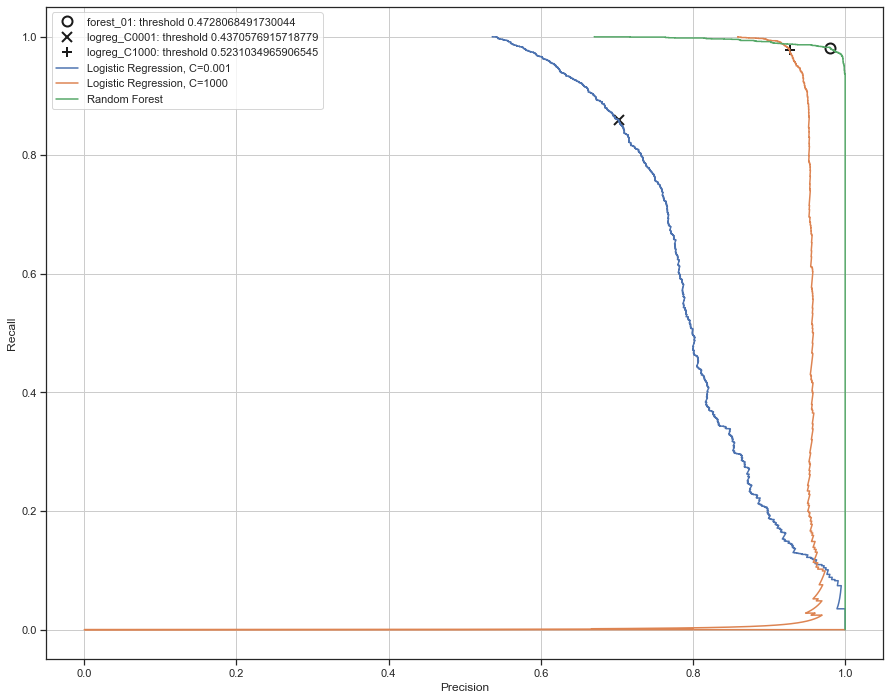

In [211]:
prec_rec_curve(
    X_train = X_train,
    y_train = y_train
    )

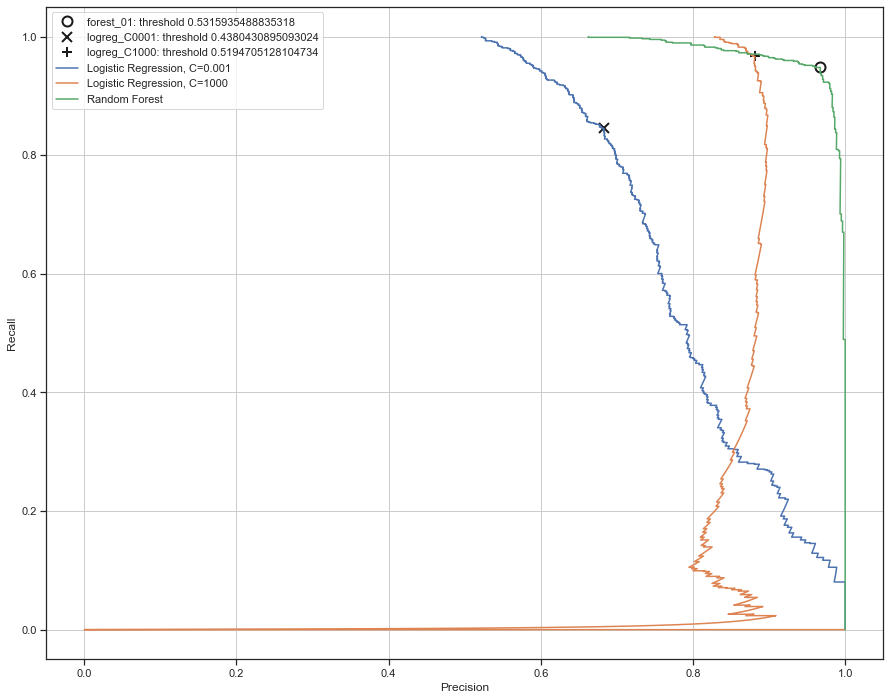

In [212]:
prec_rec_curve(
    X_train = X_test,
    y_train = y_test
    )

In [213]:
%%time
#Wall time: 19.7 s

# Area under the Recall/Precision-curves:
from sklearn.metrics import average_precision_score 

avg_precision_logreg_C0001 = (
    average_precision_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_logreg_C1000 = (
    average_precision_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )
    )

avg_precision_forest_01 = (
    average_precision_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    )


print(f"Average Precision of LogReg C=0.001: {avg_precision_logreg_C0001}"[:42])
print(f"Average Precision of LogReg C=1000:  {avg_precision_logreg_C1000}"[:42])
print(f"Average Precision of forest_01:      {avg_precision_forest_01}"[:42])

Average Precision of LogReg C=0.001: 0.797
Average Precision of LogReg C=1000:  0.867
Average Precision of forest_01:      0.988
Wall time: 748 ms


## Receiver Operating Characteristics (ROC) and AUC


In [214]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001
    global fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000
    global fpr_forest_01, tpr_forest_01, thresholds_forest_01
    
    (fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001) = (
        roc_curve(
            y_test,
            logreg_C0001.predict_proba(X_test)[:, 1]
            )
        )
    
    
    (fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000) = (
        roc_curve(
            y_test,
            logreg_C1000.predict_proba(X_test)[:, 1]
            )
        )
    
    (fpr_forest_01, tpr_forest_01, thresholds_forest_01) = (
        roc_curve(
            y_test,
            forest_01.predict_proba(X_test)[:, 1]
            )
        )

    def threshold_dot_50perc(fpr_forest_01,
                             tpr_forest_01,
                             thresholds_forest_01,
                             name,
                             dot):

        close_default_index_forest_01 = (
            pd.Series.idxmin(
                np.power(1-pd.Series(tpr_forest_01),2)
                +np.power(pd.Series(fpr_forest_01),2)
                )
            )
        
        return plt.plot(
            fpr_forest_01[close_default_index_forest_01],
            tpr_forest_01[close_default_index_forest_01],
            dot,
            markersize=10,
            label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
            fillstyle="none",
            c='k',
            mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,
             fpr_forest_01,
             linestyle='dotted',
             label="base line"
            )

    plt.plot(fpr_logreg_C0001,
             tpr_logreg_C0001,
             label="logreg_C0001"
            )
    
    plt.plot(fpr_logreg_C1000,
             tpr_logreg_C1000,
             label="logreg_C1000"
            )
    
    plt.plot(fpr_forest_01,
             tpr_forest_01,
             label="forest_01"
            )


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,
                         tpr_forest_01,
                         thresholds_forest_01,
                         'forest_01',
                         dot='^'
                        )
    
    threshold_dot_50perc(fpr_logreg_C0001,
                         tpr_logreg_C0001,
                         thresholds_logreg_C0001,
                         'logreg_C0001',
                         dot='x'
                        )
    
    threshold_dot_50perc(fpr_logreg_C1000,
                         tpr_logreg_C1000,
                         thresholds_logreg_C1000,
                         'logreg_C1000',
                         dot='+'
                        )

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [215]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc = roc_auc_score(
        y_test,
        forest_01.predict_proba(X_test)[:, 1]
        )
    
    logreg_C0001_auc = roc_auc_score(
        y_test,
        logreg_C0001.predict_proba(X_test)[:, 1]
        )
    
    logreg_C1000_auc = roc_auc_score(
        y_test,
        logreg_C1000.predict_proba(X_test)[:, 1]
        )


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


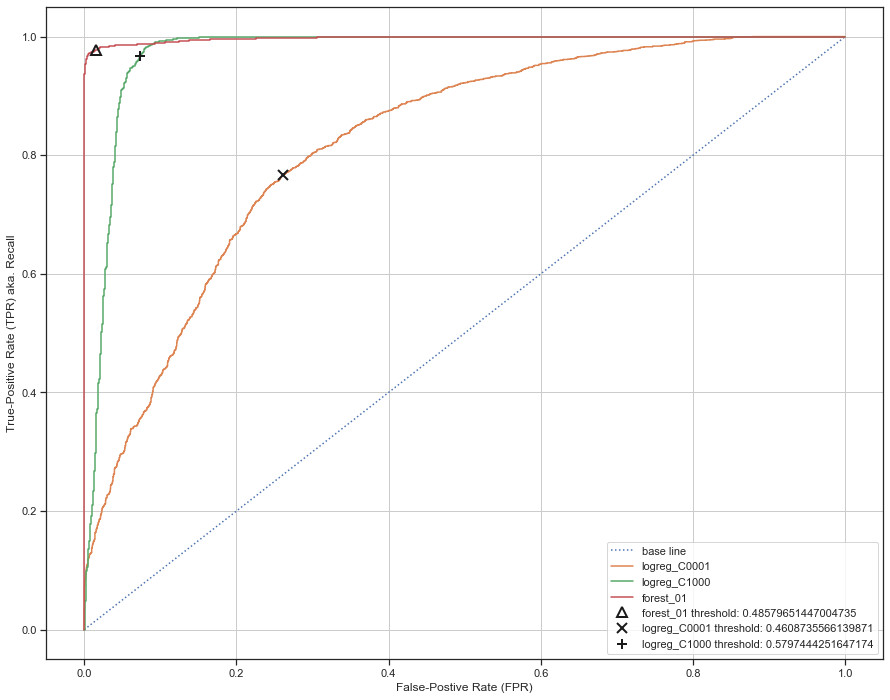

AUC for forest_01:    0.997
AUC for logreg_C0001: 0.820
AUC for logreg_C1000: 0.974
Wall time: 2.21 s


In [216]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,
                y_train
               )

roc_auc(X_train,
        y_train
       )

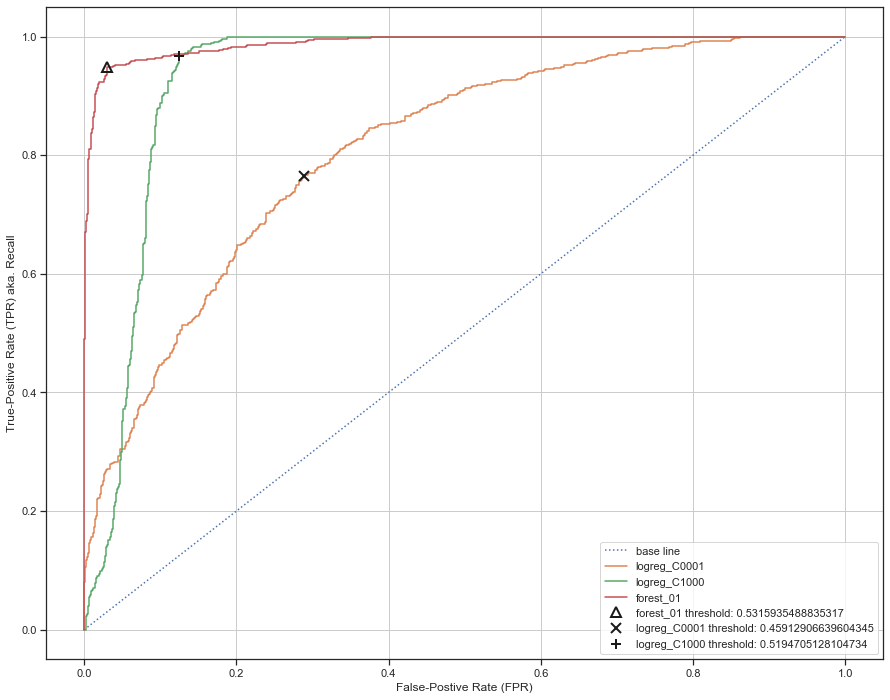

AUC for forest_01:    0.988
AUC for logreg_C0001: 0.810
AUC for logreg_C1000: 0.935
Wall time: 1.66 s


In [217]:
%%time
roc_curve_graph(X_test,
                y_test
               )

roc_auc(X_test,
        y_test
       )

# Scoring

## Create Champion Model

In [218]:
X_train_final = df_features_smote.loc[:,feature_columns_02].to_numpy()
y_train_final = y_train_smote

In [219]:
champ_model = RandomForestClassifier(
    n_estimators = 5*10**3,
    max_depth    = 10,
    criterion    = 'gini',  #criterion='gini',
    random_state = 42,
    class_weight = "balanced",
    n_jobs       = -1
    )

champ_model.fit(
    X_train_final,
    y_train_final
    )

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5000, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

## Score Class Probabilities (Booking: No/Yes)

In [220]:
print(f"Type:  {type(scoring_all)}")
print(f"Shape: {scoring_all.shape}")

Type:  <class 'pandas.core.frame.DataFrame'>
Shape: (12703, 345)


In [221]:
scoring_prob     = (
    champ_model.predict_proba(
        scoring_all.loc[:,feature_columns_02].to_numpy()
        )
    )

scoring_prob_df  = (
    pd.DataFrame(
        scoring_prob,
        columns=["Prob_0","Prob_1"]
        )
    )

scoring_all_prob = (
    pd.merge(
        scoring_all,
        scoring_prob_df,
        left_index  = True,
        right_index = True
        ).sort_values("Prob_1",ascending=False)
    )

In [222]:
scoring_all_prob.head(4)

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_11,Netto_Sum_Aus_RY_4_KW_13,Netto_Sum_Aus_RY_4_KW_15,Netto_Sum_Aus_RY_4_KW_17,Netto_Sum_Aus_RY_4_KW_19,Netto_Sum_Aus_RY_4_KW_21,Netto_Sum_Aus_RY_4_KW_23,Netto_Sum_Aus_RY_4_KW_25,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_5,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Aus_RY_4_KW_7,Netto_Sum_Aus_RY_4_KW_9,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,Netto_Sum_Res_RY_2_KW_37,Netto_Sum_Res_RY_2_KW_39,Netto_Sum_Res_RY_2_KW_41,Netto_Sum_Res_RY_2_KW_43,Netto_Sum_Res_RY_2_KW_45,Netto_Sum_Res_RY_2_KW_47,Netto_Sum_Res_RY_2_KW_49,Netto_Sum_Res_RY_2_KW_5,Netto_Sum_Res_RY_2_KW_

## Backup for comparision with Rscript

In [66]:
backup_scorings_df =  scoring_all_prob.loc[:,["Endkunde_NR","Prob_1"]]

with project_dir("vkprog\\predictions"):
    store_bin(backup_scorings_df, "20191118_pred_rebuild_with_sales_filter.feather")


09:47:30 [INFO] Started storing binary file
09:47:30 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_pred_rebuild_with_sales_filter.feather
09:47:30 [INFO] Written 300.0 KB
09:47:30 [INFO] Finished storing binary file in 0.01s (0.0s CPU)


## Adding additional information for delivery lists ``EK_LIST_2W_KOMPLETT.csv``

In [67]:
from pa_lib.file import load_bin

In [68]:
ek_info = load_bin("vkprog\\ek_info.feather")

09:47:30 [INFO] Started loading binary file
09:47:30 [INFO] Reading from file C:\Users\stc\data\vkprog\ek_info.feather
09:47:30 [INFO] Finished loading binary file in 0.04s (0.05s CPU)


In [69]:
ek_list_raw = pd.merge(scoring_all_prob,ek_info,on="Endkunde_NR", how="left")

In [70]:
ek_list_raw.shape

(12786, 385)

In [71]:
# Check _col_selection_ in file "vp2xlsx.py". 
# It's the only one that actually counts! 
# Compare with R-code to figure out the meaning.

net_columns = [col for col in ek_info.columns if col.startswith("Net_")]

col_row_filter =([
    "Insolvenz",
    #"Last_Res_Date",  # covered in listing
    #"Last_Aus_Date",  # covered in listing
    "last_CRM_Ktkt_date",
    "VB_FILTER_VON",
    "VB_FILTER_BIS"
    ])

listing = (
    ["Endkunde_NR",      # Endkunde_NR
     "Endkunde",         # Endkunde
     "EK_HB_Apg_Kurzz",  # HB_APG (based on R-script)
     "Agentur",          # Agentur
     "AG_Hauptbetreuer", # HB_Agentur   
     "PLZ",              # PLZ
     "GEMEINDE"]        # Ort
    
     +net_columns       # Net_2015, Net_2016, Net_2017, Net_2018, Net_2019 
    
     +["letzte_VBs",     # (bd, aggregiert)
       "Letzter_Kontakt", # KZ_letzter_Ktkt (crm)
       "Kanal",           #(crm)
       "Betreff",         #(crm)    
       "Last_Res_Date", # Letzte_Kamp_erfasst
       "Last_Aus_Date", # letzte_Kamp_Beginn
       "VERKAUFS_GEBIETS_CODE", # Verkaufsgebiet
       "VB_VKGEB",      
       "Prob_1"        # prob_KW (from here, good good.)
       ]
    # Needed for row_filter
    + col_row_filter
    )

ek_list = (ek_list_raw
    .loc[:,listing]
    .rename(columns={
        "EK_HB_Apg_Kurzz": "HB_APG",
        "AG_Hauptbetreuer": "HB_Agentur",
        "GEMEINDE": "Ort",
        "Letzter_Kontakt": "letzter_Kontakt",
        "Last_Res_Date": "letzte_Kamp_erfasst",
        "Last_Aus_Date":"letzte_Kamp_Beginn",
        "VERKAUFS_GEBIETS_CODE": "Verkaufsgebiet",
        "VB_VKGEB": "VB_VK_Geb",
        "Prob_1": "prob_KW"
    })       
    )

print(f"ek_list.shape: {ek_list.shape}")

ek_list.shape: (12786, 25)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [72]:
ek_list.sample(10)

,Endkunde_NR,Endkunde,HB_APG,Agentur,HB_Agentur,PLZ,Ort,Net_2015,Net_2016,Net_2017,Net_2018,Net_2019,letzte_VBs,letzter_Kontakt,Kanal,Betreff,letzte_Kamp_erfasst,letzte_Kamp_Beginn,Verkaufsgebiet,VB_VK_Geb,prob_KW,Insolvenz,last_CRM_Ktkt_date,VB_FILTER_VON,VB_FILTER_BIS
2248,477059,Obrasso Classic Events GmbH,OSS,None,None,6002,Luzern,25728.0,26763.0,5585.0,6440.0,5585.0,NaN,OSS,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-10-15,2020-01-06,V-M07,JCO,0.407010,None,2019-10-27,NaT,NaT
8989,628168,Fondazione Ticino Cuore,LPA,None,None,6900,Lugano,0.0,0.0,6412.0,0.0,0.0,NaN,LPA,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2017-01-31,2017-05-22,V-S02,TRA,0.211325,None,2019-10-26,NaT,NaT
11090,569264,Humbel Spezialitätenbrennerei AG,PAL,Girod Gründisch & Partner,FGR,5608,Stetten AG,2122.0,2066.0,2137.0,2081.0,0.0,NaN,WIM,E-Mail,AW: Bestätigung 1009739 - Humbel Spezialitäten...,2018-09-06,2018-11-05,V-M06,OSS,0.128434,None,2019-09-24,NaT,NaT
11739,467035,Mesey Daniel,VIT,None,None,2052,Fontainemelon,1512.0,6507.0,0.0,2520.0,0.0,NaN,None,None,None,2018-05-03,2018-07-09,V-W04,VIT,0.104326,None,NaT,NaT,NaT
8588,607445,Curling 2006 GmbH,None,None,None,4052,Basel,19127.0,15000.0,0.0,0.0,0.0,NaN,ROF,Telefon,einmaliger Anlass,2016-04-11,2016-04-11,V-M01,RPO,0.224747,None,2017-02-02,NaT,NaT
9671,624490,Orchestre Symphonique Bande-Son,MZB,None,None,1002,Lausanne,0.0,784.0,4796.0,0.0,0.0,NaN,MZB,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2017-12-08,2018-03-05,V-W03,MZB,0.181138,None,2019-10-26,NaT,NaT
12762,628092,SERVAS Schweiz,CGA,None,None,8125,Zollikerberg,0.0,0.0,249.0,0.0,0.0,NaN,None,None,None,2017-02-13,2017-06-17,V-Z01,,0.050334,None,NaT,NaT,NaT
3772,119661,Ringler Informatik AG,DCI,One Marketing Services AG,CGA,6340,Baar,0.0,0.0,0.0,31184.0,56462.0,NaN,MOE,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-03-01,2019-04-01,"V-Z03,V-Z02",,0.350758,None,2019-10-25,NaT,NaT
5900,575309,Kimura Shukokai Karate Wetzikon GmbH,MBU,None,None,8620,Wetzikon ZH,0.0,0.0,0.0,0.0,772.0,NaN,MBU,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-01-31,2019-03-11,V-O03,ACO,0.294831,None,2019-10-27,NaT,NaT
3401,113039,"Manor, Nordmann & Co., Luzern",JCO,None,None,6020,Emmenbrücke 3,0.0,31000.0,20000.0,20000.0,8891.0,NaN,JCO,E-Mail,Neujahrsaktion - Neujahrsaktion KW50-04 Mailing,2019-09-26,2019-11-01,V-M07,JCO,0.362534,None,2019-10-27,2019-06-25,NaT


In [73]:
desc_col(ek_list)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/12786,12786
Endkunde,object,0/12786,12184
HB_APG,object,319/12467,63
Agentur,object,7532/5254,1801
HB_Agentur,object,7576/5210,93
PLZ,int64,0/12786,2009
Ort,object,6/12780,1950
Net_2015,float64,2/12784,3675
Net_2016,float64,2/12784,4512
Net_2017,float64,2/12784,4585


## Deployment for ``vp2xlsx.py``

In [74]:
with project_dir("vkprog\\predictions"):
    store_bin(ek_list, "20191118_ek_list.feather")

09:47:31 [INFO] Started storing binary file
09:47:31 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20191118_ek_list.feather
09:47:31 [INFO] Written 3.2 MB
09:47:31 [INFO] Finished storing binary file in 0.03s (0.16s CPU)


# Appendix

## Mutual Information

In [ ]:
%%time
mu_in = (mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced))

In [ ]:
print(mu_in.shape)
print(feature_columns.shape)

In [ ]:
 mu_in_df = (
     pd.DataFrame(
         {'Feature':           feature_columns,
          'Mutual_Information': mu_in}
         )
     .sort_values(by        = 'Mutual_Information',
                  ascending = False
                 )
     .reset_index(drop=True)
     )

In [ ]:
display(mu_in_df.head(50))

In [ ]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [ ]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [ ]:
mu_in_cutoff(0.07)

In [ ]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [ ]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

In [ ]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Univariate Analysis

In [ ]:
for feature in feature_columns:
    print(feature)
    print(len(training_all.loc[training_all.loc[:,feature] > 0, feature]))
    boxplot_histogram(training_all.loc[training_all.loc[:,feature] > 0, feature])

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
%%time
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
